In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import rdPartialCharges
from rdkit.Chem.Draw import IPythonConsole

In [2]:
mol = Chem.MolFromSmiles("Oc1ccccc1")

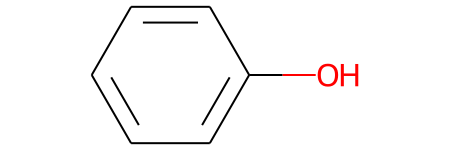

In [3]:
mol

In [4]:
rdPartialCharges.ComputeGasteigerCharges(mol)

In [5]:
atom = mol.GetAtomWithIdx(0)

In [6]:
for atom in mol.GetAtoms():
    print(f"atom: {atom.GetSymbol()}, charge: {atom.GetDoubleProp('_GasteigerCharge')}")

atom: O, charge: -0.5079669948663066
atom: C, charge: 0.11507481947527982
atom: C, charge: -0.02022944427290262
atom: C, charge: -0.058593573972889716
atom: C, charge: -0.06199998663933999
atom: C, charge: -0.058593573972889716
atom: C, charge: -0.02022944427290262


In [1]:
import torch

from contextSub.loader import MoleculeDataset
from contextSub.dataloader import DataLoaderPubchemContext, ExtractPubchemSubstructs
from contextSub.model import GNN
from contextSub.pretrain_contextsub import cycle_index
from torch_geometric.nn import global_mean_pool

In [2]:
criterion = torch.nn.MSELoss()

In [3]:
model = GNN(
    5,
    300,
    JK="last",
    drop_ratio=0.3,
    gnn_type="gin",
    partial_charge=True
).to("cuda:3")

In [4]:
dataset = MoleculeDataset(
    "contextSub/dataset/chembl",
    dataset="chembl",
    transform=ExtractPubchemSubstructs(5, 4, 7, partial_charge=True),
    partial_charge=True,
    )

In [5]:
loader = DataLoaderPubchemContext(
    dataset, 
    batch_size=64,
    shuffle=False,
)

In [6]:
len(loader)

7115

In [7]:
for i, batch in enumerate(loader):
    batch = batch.to("cuda:3")
    emb = model(batch.x_substruct, batch.edge_index_substruct, batch.edge_attr_substruct)
    substruct_rep = emb[batch.center_substruct_idx]
    substruct_rep = global_mean_pool(substruct_rep, batch.batch_center_substruct)
    substruct_rep = substruct_rep / torch.sqrt(torch.sum(torch.square(substruct_rep), dim=1, keepdim=True))
    
    overlapped_node_rep = model(
        batch.x_context, batch.edge_index_context, batch.edge_attr_context
    )[batch.overlap_context_substruct_idx]
    context_rep = global_mean_pool(overlapped_node_rep, batch.batch_overlapped_context)
    context_rep = context_rep / torch.sqrt(torch.sum(torch.square(context_rep), dim=1, keepdim=True))
    
    pred_pos = torch.sum(substruct_rep * context_rep, dim=1)
    loss_pos = criterion(
            pred_pos.double(), torch.ones(len(pred_pos)).to(pred_pos.device).double()
        )
    print(i, loss_pos)
    neg_context_rep = torch.cat(
        [
            context_rep[cycle_index(len(context_rep), i + 1)]
            for i in range(3)
        ],
        dim=0,
    )
    pred_neg = torch.sum(
        substruct_rep.repeat((3, 1)) * neg_context_rep, dim=1
    )
    loss_neg = criterion(
        pred_neg.double(), torch.zeros(len(pred_neg)).to(pred_neg.device).double()
    )
    print(f"pos loss: {loss_pos.detach().cpu().item()}, neg loss: {loss_neg.detach().cpu().item()}", end="\r")

0 tensor(1.0104, device='cuda:3', dtype=torch.float64, grad_fn=<MseLossBackward>)
1 tensor(0.9350, device='cuda:3', dtype=torch.float64, grad_fn=<MseLossBackward>)
2 tensor(1.0172, device='cuda:3', dtype=torch.float64, grad_fn=<MseLossBackward>)
3 tensor(0.9440, device='cuda:3', dtype=torch.float64, grad_fn=<MseLossBackward>)
4 tensor(1.0705, device='cuda:3', dtype=torch.float64, grad_fn=<MseLossBackward>)
5 tensor(1.0724, device='cuda:3', dtype=torch.float64, grad_fn=<MseLossBackward>)
6 tensor(1.0113, device='cuda:3', dtype=torch.float64, grad_fn=<MseLossBackward>)
7 tensor(1.0616, device='cuda:3', dtype=torch.float64, grad_fn=<MseLossBackward>)
8 tensor(0.9754, device='cuda:3', dtype=torch.float64, grad_fn=<MseLossBackward>)
9 tensor(0.9881, device='cuda:3', dtype=torch.float64, grad_fn=<MseLossBackward>)
10 tensor(1.0079, device='cuda:3', dtype=torch.float64, grad_fn=<MseLossBackward>)
11 tensor(0.9889, device='cuda:3', dtype=torch.float64, grad_fn=<MseLossBackward>)
12 tensor(1.08

KeyboardInterrupt: 

In [8]:
for i, batch in enumerate(loader):
    if i == 64:
        break

In [9]:
batch = batch.to("cuda:3")
emb = model(batch.x_substruct, batch.edge_index_substruct, batch.edge_attr_substruct)
substruct_rep = emb[batch.center_substruct_idx]
substruct_rep = global_mean_pool(substruct_rep, batch.batch_center_substruct)
substruct_rep = substruct_rep / torch.sqrt(torch.sum(torch.square(substruct_rep), dim=1, keepdim=True))

overlapped_node_rep = model(
    batch.x_context, batch.edge_index_context, batch.edge_attr_context
)[batch.overlap_context_substruct_idx]
context_rep = global_mean_pool(overlapped_node_rep, batch.batch_overlapped_context)
context_rep = context_rep / torch.sqrt(torch.sum(torch.square(context_rep), dim=1, keepdim=True))

pred_pos = torch.sum(substruct_rep * context_rep, dim=1)
loss_pos = criterion(
        pred_pos.double(), torch.ones(len(pred_pos)).to(pred_pos.device).double()
    )

In [10]:
loss_pos

tensor(0.9380, device='cuda:3', dtype=torch.float64, grad_fn=<MseLossBackward>)

In [13]:
batch.x

In [167]:
loss_pos

tensor(nan, device='cuda:3', dtype=torch.float64, grad_fn=<MseLossBackward>)

In [119]:
emb = model(batch.x_substruct, batch.edge_index_substruct, batch.edge_attr_substruct)

In [120]:
substruct_rep = model(
            batch.x_substruct, batch.edge_index_substruct, batch.edge_attr_substruct
        )[batch.center_substruct_idx]

In [121]:
substruct_rep = global_mean_pool(substruct_rep, batch.batch_center_substruct)
substruct_rep

tensor([[-7.5337e-02, -1.9164e-01,  0.0000e+00,  ..., -4.2172e-01,
         -8.2472e-02, -5.1658e-01],
        [ 7.1587e-02,  1.5313e+00, -4.7230e-01,  ...,  1.5220e-03,
          8.8076e-01, -4.9454e-01],
        [ 3.5013e-01, -2.4711e-01,  3.0130e-01,  ..., -4.8009e-01,
          1.9063e+00,  2.6722e-01],
        ...,
        [ 4.5720e-01, -2.2715e+00,  7.8047e-01,  ...,  1.3600e-04,
          9.8082e-01, -2.2471e-01],
        [ 3.9004e-01, -5.4876e-01, -3.2737e-02,  ..., -1.3432e-01,
          3.2223e-01, -1.1531e+00],
        [-8.7112e-01,  1.5297e+00,  8.6395e-01,  ...,  1.7881e+00,
         -1.2241e+00, -9.6895e-01]], grad_fn=<TrueDivideBackward0>)

In [122]:
substruct_rep = substruct_rep / torch.sqrt(torch.sum(torch.square(substruct_rep), dim=1, keepdim=True))

In [123]:
overlapped_node_rep = model(
            batch.x_context, batch.edge_index_context, batch.edge_attr_context
        )[batch.overlap_context_substruct_idx]

In [124]:
context_rep = global_mean_pool(overlapped_node_rep, batch.batch_overlapped_context)

In [125]:
context_rep = context_rep / torch.sqrt(torch.sum(torch.square(context_rep), dim=1, keepdim=True))

In [126]:
context_rep

tensor([[-0.0211, -0.0006,  0.0187,  ..., -0.0283, -0.0541,  0.0351],
        [ 0.0998, -0.0679,  0.1083,  ..., -0.1342, -0.0004, -0.0775],
        [ 0.0943,  0.0000,  0.1143,  ..., -0.1259, -0.0133, -0.0732],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0220, -0.0207, -0.0280],
        [ 0.0653, -0.0672,  0.0045,  ..., -0.0233, -0.0233, -0.1120],
        [ 0.0008, -0.0135, -0.0529,  ...,  0.0233,  0.0000,  0.0000]],
       grad_fn=<DivBackward0>)

In [127]:
pred_pos = torch.sum(substruct_rep * context_rep, dim=1)

In [128]:
pred_pos

tensor([-0.0844, -0.0946,  0.1987, -0.0153, -0.1370, -0.0046, -0.2096, -0.1267,
        -0.0306, -0.3193,  0.0125, -0.1985,  0.1487, -0.2657,  0.0526, -0.2163,
         0.0043,  0.2434,  0.1024, -0.0739, -0.1243,  0.1585,  0.0167, -0.0431,
        -0.0264,  0.2503, -0.2353,  0.1282,  0.1572,  0.1249, -0.0481,  0.1887,
        -0.0230, -0.0125,  0.1293,  0.0110, -0.0942, -0.3237, -0.0195, -0.0261,
        -0.2965, -0.0540,  0.1684, -0.1774, -0.1459, -0.2923,  0.1879,  0.0192,
         0.0315, -0.3676, -0.1907, -0.2800,  0.0075,  0.0594,  0.1754, -0.0460],
       grad_fn=<SumBackward1>)

In [130]:
loss_pos = criterion(
            pred_pos.double(), torch.ones(len(pred_pos)).to(pred_pos.device).double()
        )

In [131]:
loss_pos

tensor(1.0985, dtype=torch.float64, grad_fn=<MseLossBackward>)

In [38]:
neg_context_rep = torch.cat(
    [
        context_rep[cycle_index(len(context_rep), i + 1)]
        for i in range(3)
    ],
    dim=0,
)
pred_neg = torch.sum(
    substruct_rep.repeat((3, 1)) * neg_context_rep, dim=1
)

In [39]:
pred_neg

tensor([-4.8300e+01, -7.1100e+01, -6.7695e+00,  1.6576e+01, -5.9739e+01,
         5.1073e+01, -1.0552e-01,  1.8496e+01,  1.6321e+01,  4.5274e+01,
         9.0776e+00, -5.0758e+00, -9.1720e+00, -4.0606e+00,  3.1683e+01,
         1.0073e+02,  2.3170e+01, -1.0189e+01, -1.4663e+01, -3.4550e+01,
         5.4161e+00, -1.1773e+01,  4.3702e+01, -1.2723e+01,  1.3321e+01,
         3.0428e+00, -3.8171e+00, -9.0349e+00, -1.4517e+01,  1.1931e+01,
         5.4987e+00,  2.1240e+01,  2.5171e+02, -1.3239e+01, -7.3590e+01,
        -1.5793e+01, -9.2284e+01, -1.4017e+01, -1.1944e+01, -1.5018e+01,
        -4.5376e+01,  2.2097e+01, -8.6993e+00, -1.8209e+01, -1.1089e+01,
        -1.3407e+02, -6.7079e+00,  1.8216e+01, -4.1682e+00, -2.9376e+01,
        -2.9827e+01,  1.0635e+01,  3.1265e+01, -3.7631e+01,  3.8146e+01,
         2.3992e+00, -1.9419e+01, -7.2737e+00,  3.8266e+00, -3.9222e+01,
         7.0997e-01, -3.2463e+01, -8.0240e+01, -5.0322e+01, -3.2498e+01,
        -1.7245e+01,  2.4149e+01, -4.6115e+01,  1.1

In [40]:
loss_neg = criterion(
    pred_neg.double(), torch.zeros(len(pred_neg)).to(pred_neg.device).double()
)

In [41]:
loss_neg

tensor(12.1956, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [1]:
import torch
from torch.nn import Embedding

In [2]:
emb = Embedding(5, 100)

In [5]:
emb(torch.tensor([1, 2])).dtype

torch.float32

In [15]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, rdPartialCharges

In [2]:
chembl_df = pd.read_csv("contextSub/dataset/chembl/processed/smiles.csv", header=None)

In [44]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 500, 200

In [28]:
def plot_gasterger_charges(smiles):
    m = Chem.MolFromSmiles(smiles)
    AllChem.ComputeGasteigerCharges(m)
    for at in m.GetAtoms():
        lbl = '%.2f'%(at.GetDoubleProp("_GasteigerCharge"))
        at.SetProp('atomNote',lbl)
    return m

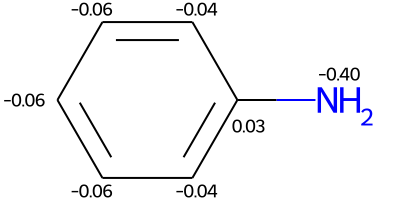

In [29]:
plot_gasterger_charges("Nc1ccccc1")

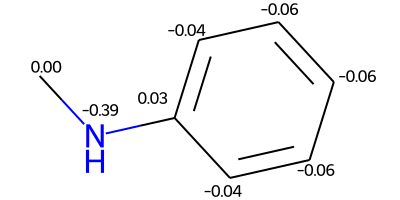

In [30]:
plot_gasterger_charges("CNc1ccccc1")

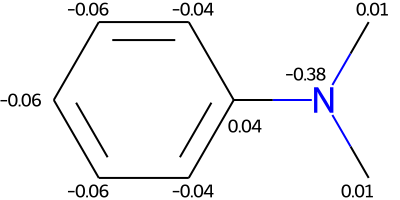

In [31]:
plot_gasterger_charges("CN(C)c1ccccc1")

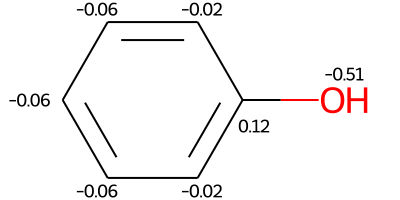

In [32]:
plot_gasterger_charges("Oc1ccccc1")

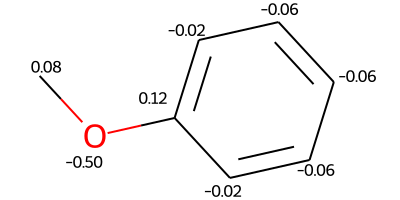

In [33]:
plot_gasterger_charges("COc1ccccc1")

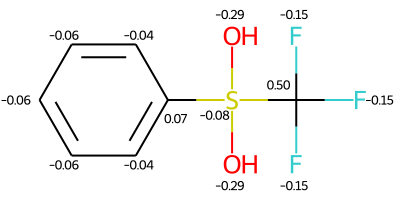

In [34]:
plot_gasterger_charges("OS(O)(c1ccccc1)C(F)(F)F")

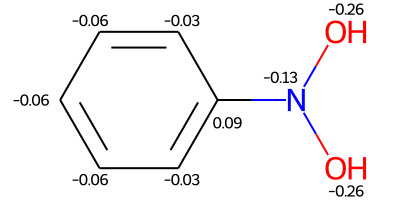

In [35]:
plot_gasterger_charges("ON(O)c1ccccc1")

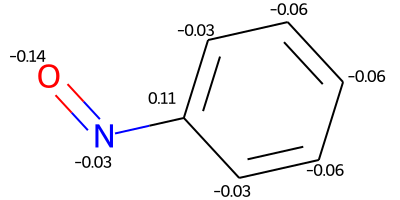

In [36]:
plot_gasterger_charges("O=Nc1ccccc1")

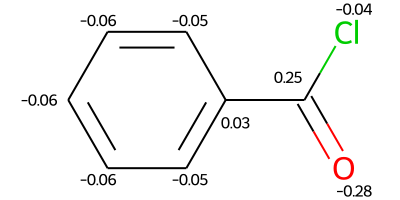

In [37]:
plot_gasterger_charges("O=C(Cl)c1ccccc1")

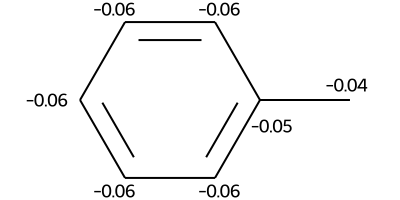

In [38]:
plot_gasterger_charges("Cc1ccccc1")

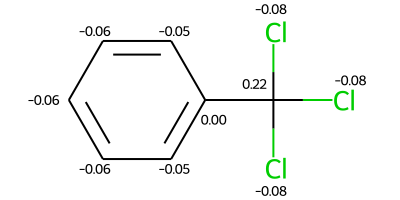

In [39]:
plot_gasterger_charges("ClC(Cl)(Cl)c1ccccc1")

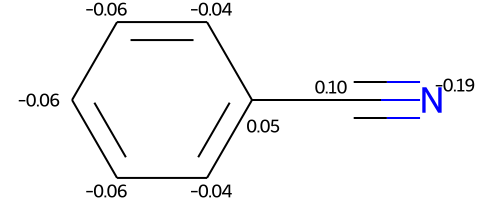

In [45]:
plot_gasterger_charges("N#Cc1ccccc1")